### Part 1: Fitting a 2D Image

In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import time
import gdown

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


We first download the image from the web. We normalize the image so the pixels are in between the range of [0,1].

In [9]:
url = "https://drive.google.com/file/d/1-0HAp_EA2xBHXaZkJfxIMczBqFseNia6/view?usp=sharing"
gdown.download(url=url, output='starry_night.jpg', quiet=False, fuzzy=True)

# Load painting image
painting = imageio.imread("starry_night.jpg")
painting = torch.from_numpy(np.array(painting, dtype=np.float32)/255.).to(device)
height_painting, width_painting = painting.shape[:2]

Downloading...
From: https://drive.google.com/uc?id=1-0HAp_EA2xBHXaZkJfxIMczBqFseNia6
To: /content/starry_night.jpg
100%|██████████| 5.65k/5.65k [00:00<00:00, 10.1MB/s]


1.1 Positional encoding is used to map continuous input coordinates into a higher dimensional space to enable a neural network to approximate a higher frequency function.

In [10]:
def positional_encoding(x, num_frequencies=6, incl_input=True):

    """
    Apply positional encoding to the input.

    Args:
    x (torch.Tensor): Input tensor to be positionally encoded.
      The dimension of x is [N, D], where N is the number of input coordinates,
      and D is the dimension of the input coordinate.
    num_frequencies (optional, int): The number of frequencies used in
     the positional encoding (default: 6).
    incl_input (optional, bool): If True, concatenate the input with the
        computed positional encoding (default: True).

    Returns:
    (torch.Tensor): Positional encoding of the input tensor.
    """

    results = []
    if incl_input:
        results.append(x)
    # encode input tensor and append the encoded tensor to the list of results.
    for i in range(num_frequencies):
        sin_encoding = torch.sin(2 ** i * np.pi * x)
        cos_encoding = torch.cos(2 ** i * np.pi * x)
        results.append(sin_encoding)
        results.append(cos_encoding)

    return torch.cat(results, dim=-1)

1.2 Complete the class model_2d() that will be used to fit the 2D image.


In [11]:
class model_2d(nn.Module):

    """
    Define a 2D model comprising of three fully connected layers,
    two relu activations and one sigmoid activation.
    """

    def __init__(self, filter_size=128, num_frequencies=6):
        super().__init__()
        input_dim = 2 * (1 + 2 * num_frequencies)
        self.layer_in = nn.Linear(input_dim, filter_size)
        self.layer = nn.Linear(filter_size, filter_size)
        self.layer_out = nn.Linear(filter_size, 3)


    def forward(self, x):
        x = nn.functional.relu(self.layer_in(x))
        x = nn.functional.relu(self.layer(x))
        x = torch.sigmoid(self.layer_out(x))

        return x

In [12]:
model_2d()

model_2d(
  (layer_in): Linear(in_features=26, out_features=128, bias=True)
  (layer): Linear(in_features=128, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=3, bias=True)
)

In [13]:
def normalize_coord(height, width, num_frequencies=6):

    """
    Creates the 2D normalized coordinates, and applies positional encoding to them

    Args:
    height (int): Height of the image
    width (int): Width of the image
    num_frequencies (optional, int): The number of frequencies used in
      the positional encoding (default: 6).

    Returns:
    (torch.Tensor): Returns the 2D normalized coordinates after applying positional encoding to them.
    """

    y_coords, x_coords = torch.meshgrid(torch.linspace(0, 1, height), torch.linspace(0, 1, width))
    coords = torch.stack((x_coords, y_coords), dim=-1).view(-1, 2)

    embedded_coordinates = positional_encoding(coords, num_frequencies)

    return embedded_coordinates

Train the model to fit the 2D image.

In [14]:
def train_2d_model(test_img, num_frequencies, device, model=model_2d, positional_encoding=positional_encoding, show=True):

    # Optimizer parameters
    lr = 5e-4
    iterations = 10000
    height, width = test_img.shape[:2]

    # Number of iters after which stats are displayed
    display = 2000

    # Define the model and initialize its weights.
    model2d = model(num_frequencies=num_frequencies)
    model2d.to(device)

    def weights_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)

    model2d.apply(weights_init)

    # Define the optimizer
    optimizer = torch.optim.Adam(model2d.parameters(), lr=lr)

    # Seed RNG, for repeatability
    seed = 5670
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Lists to log metrics etc.
    psnrs = []
    iternums = []

    t = time.time()
    t0 = time.time()

    # Create the 2D normalized coordinates, and apply positional encoding to them
    coords = normalize_coord(height, width, num_frequencies).to(device)

    for i in range(iterations+1):
        optimizer.zero_grad()
        # Run one iteration
        pred = model2d(coords).reshape(105, 133, 3)

        # Compute mean-squared error between the predicted and target images. Backprop!
        loss = F.mse_loss(pred, test_img)
        loss.backward()
        optimizer.step()


        # Display images/plots/stats
        if i % display == 0 and show:

            # Calculate psnr
            mse = loss.item()
            psnr = 10 * torch.log10(torch.tensor(1.0) / mse)


            print("Iteration %d " % i, "Loss: %.4f " % loss.item(), "PSNR: %.2f" % psnr.item(), \
                "Time: %.2f secs per iter" % ((time.time() - t) / display), "%.2f secs in total" % (time.time() - t0))
            t = time.time()

            psnrs.append(psnr.item())
            iternums.append(i)

            plt.figure(figsize=(13, 4))
            plt.subplot(131)
            plt.imshow(pred.detach().cpu().numpy())
            plt.title(f"Iteration {i}")
            plt.subplot(132)
            plt.imshow(test_img.cpu().numpy())
            plt.title("Target image")
            plt.subplot(133)
            plt.plot(iternums, psnrs)
            plt.title("PSNR")
            plt.show()

    print('Done!')
    torch.save(model2d.state_dict(),'model_2d_' + str(num_frequencies) + 'freq.pt')
    plt.imsave('van_gogh_' + str(num_frequencies) + 'freq.png',pred.detach().cpu().numpy())
    return pred.detach().cpu()

In [ ]:
_ = train_2d_model(test_img=painting, num_frequencies=4, device=device)

### Part 2: Fitting a 3D Image

In [ ]:
import os
import gdown
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
url = "https://drive.google.com/file/d/13eBK_LWxs4SkruFKH7glKK9jwQU1BkXK/view?usp=sharing"
gdown.download(url=url, output='lego_data.npz', quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=13eBK_LWxs4SkruFKH7glKK9jwQU1BkXK
To: /content/lego_data.npz
100%|██████████| 12.7M/12.7M [00:00<00:00, 58.8MB/s]


'lego_data.npz'

Here, we load the data that is comprised by the images, the R and T matrices of each camera position with respect to the world coordinates and the intrinsics parameters K of the camera.

In [ ]:
# Load input images, poses, and intrinsics
data = np.load("lego_data.npz")

# Images
images = data["images"]

# Height and width of each image
height, width = images.shape[1:3]

# Camera extrinsics (poses)
poses = data["poses"]
poses = torch.from_numpy(poses).to(device)
print(poses.shape)

# Camera intrinsics
intrinsics = data["intrinsics"]
intrinsics = torch.from_numpy(intrinsics).to(device)

# Hold one image out (for test).
test_image, test_pose = images[101], poses[101]
test_image = torch.from_numpy(test_image).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)

plt.imshow(test_image.detach().cpu().numpy())
plt.show()

print(data)

2.1 Calculates the rays that pass through all the pixels of an HxW image

In [ ]:
def get_rays(height, width, intrinsics, w_R_c, w_T_c):

    """
    Compute the origin and direction of rays passing through all pixels of an image (one ray per pixel).

    Args:
    height: the height of an image.
    width: the width of an image.
    intrinsics: camera intrinsics matrix of shape (3, 3).
    w_R_c: Rotation matrix of shape (3,3) from camera to world coordinates.
    w_T_c: Translation vector of shape (3,1) that transforms

    Returns:
    ray_origins (torch.Tensor): A tensor of shape (height, width, 3) denoting the centers of
      each ray. Note that desipte that all ray share the same origin, here we ask you to return
      the ray origin for each ray as (height, width, 3).
    ray_directions (torch.Tensor): A tensor of shape (height, width, 3) denoting the
      direction of each ray.
    """

    device = intrinsics.device
    ray_directions = torch.zeros((height, width, 3), device=device)  # placeholder
    ray_origins = torch.zeros((height, width, 3), device=device)  # placeholder

    u, v = torch.meshgrid(torch.arange(height,device=device), torch.arange(width,device=device))
    u = (u - intrinsics[1,2]) / intrinsics[1,1]
    v = (v - intrinsics[0,2]) / intrinsics[0,0]

    directions = torch.stack([v, u, torch.ones_like(v)], dim=-1)

    ray_directions = torch.einsum('ij,klj->kli', w_R_c, directions)
    ray_origins = torch.tile(w_T_c.reshape(1, 3), (height, height, 1))

    return ray_origins, ray_directions

Visualize how the dataset is created, from which point of view each image has been captured for the 3D object. What we want to achieve here, is to being able to interpolate between these given views and synthesize new realistic views of the 3D object.

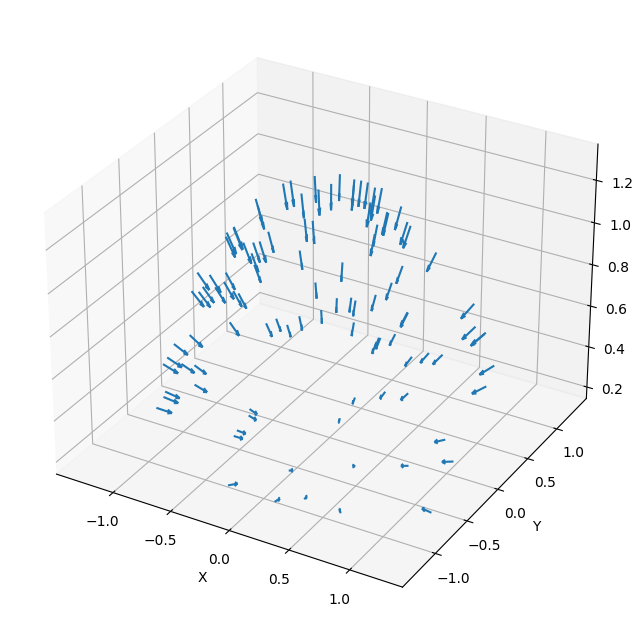

In [ ]:
def plot_all_poses(poses):

    origins = np.array([pose[:3, 3] for pose in poses])
    directions = np.array([pose[:3, :3] @ np.array([0, 0, 1]) for pose in poses])

    ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
    _ = ax.quiver(origins[..., 0].flatten(),
                  origins[..., 1].flatten(),
                  origins[..., 2].flatten(),
                  directions[..., 0].flatten(),
                  directions[..., 1].flatten(),
                  directions[..., 2].flatten(), length=0.12, normalize=True)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('z')
    plt.show()

plot_all_poses(data['poses'])

2.2 Implement the sampling of points along a given ray.

In [ ]:
def stratified_sampling(ray_origins, ray_directions, near, far, samples):

    """
    Sample 3D points on the given rays. The near and far variables indicate the bounds of sampling range.

    Args:
    ray_origins: Origin of each ray in the "bundle" as returned by the
      get_rays() function. Shape: (height, width, 3).
    ray_directions: Direction of each ray in the "bundle" as returned by the
      get_rays() function. Shape: (height, width, 3).
    near: The 'near' extent of the bounding volume.
    far:  The 'far' extent of the bounding volume.
    samples: Number of samples to be drawn along each ray.

    Returns:
    ray_points: Query 3D points along each ray. Shape: (height, width, samples, 3).
    depth_points: Sampled depth values along each ray. Shape: (height, width, samples).
    """

    height, width, _ = ray_origins.shape

    depth_points = torch.linspace(near, far, samples, device=ray_origins.device)
    depth_points = depth_points.unsqueeze(0).unsqueeze(0).expand(height, width, samples)

    ray_points = ray_origins.unsqueeze(2) + depth_points.unsqueeze(-1) * ray_directions.unsqueeze(2)

    return ray_points, depth_points

2.3 Define the network architecture of NeRF along with a function that divided data into chunks to avoid memory leaks during training.

In [ ]:
class nerf_model(nn.Module):

    """
    Define a NeRF model comprising eight fully connected layers and following the
    architecture described in the NeRF paper.
    """

    def __init__(self, filter_size=256, num_x_frequencies=6, num_d_frequencies=3):
        super().__init__()

        self.layers = nn.ModuleDict({
            'layer_1': nn.Linear(3 * num_x_frequencies * 2 + 3, filter_size),
            'layer_2': nn.Linear(filter_size, filter_size),
            'layer_3': nn.Linear(filter_size, filter_size),
            'layer_4': nn.Linear(filter_size, filter_size),
            'layer_5': nn.Linear(filter_size, filter_size),
            'layer_6': nn.Linear(filter_size+3 * num_x_frequencies * 2 + 3, filter_size),
            'layer_7': nn.Linear(filter_size, filter_size),
            'layer_8': nn.Linear(filter_size, filter_size),
            'layer_s': nn.Linear(filter_size, 1),
            'layer_9': nn.Linear(filter_size, filter_size),
            'layer_10': nn.Linear(filter_size+3 * num_d_frequencies * 2 + 3, 128),
            'layer_11': nn.Linear(128, 3),
        })



    def forward(self, x, d):
        x_encoded = x
        for i in range(1, 6):
            x_encoded = F.relu(self.layers[f'layer_{i}'](x_encoded))
        x_encoded = torch.cat([x_encoded, x], dim=-1)
        for i in range(6, 9):
            x_encoded = F.relu(self.layers[f'layer_{i}'](x_encoded))

        sigma = self.layers['layer_s'](x_encoded)
        x_encoded = self.layers['layer_9'](x_encoded)
        x_encoded = torch.cat([x_encoded, d], dim=-1)
        x_encoded = F.relu(self.layers['layer_10'](x_encoded))
        rgb = torch.sigmoid(self.layers['layer_11'](x_encoded))

        return rgb, sigma

In [ ]:
def get_batches(ray_points, ray_directions, num_x_frequencies, num_d_frequencies):

    def get_chunks(inputs, chunksize = 2**15):
        """
        This fuction gets an array/list as input and returns a list of chunks of the initial array/list
        """
        return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

    """
    This function returns chunks of the ray points and directions to avoid memory errors with the
    neural network. It also applies positional encoding to the input points and directions before
    dividing them into chunks, as well as normalizing and populating the directions.
    """
    norms = torch.norm(ray_directions, dim=-1, keepdim=True)
    normalized_directions = ray_directions / norms

    replicated_directions = normalized_directions.unsqueeze(-2).repeat(1, 1, ray_points.shape[2], 1)

    flattened_ray_points = ray_points.reshape(-1, 3)
    flattened_ray_directions = replicated_directions.reshape(-1, 3)

    encoded_ray_points = positional_encoding(flattened_ray_points, num_x_frequencies)
    encoded_ray_directions = positional_encoding(flattened_ray_directions, num_d_frequencies)

    ray_points_batches = get_chunks(encoded_ray_points)
    ray_directions_batches = get_chunks(encoded_ray_directions)


    return ray_points_batches, ray_directions_batches

2.4 Compute the compositing weights of samples on camera ray and then complete the volumetric rendering procedure to reconstruct a whole RGB image from the sampled points and the outputs of the neural network.

In [ ]:
def volumetric_rendering(rgb, sigma, depth_points):

    """
    Differentiably renders a radiance field, given the origin of each ray in the
    "bundle", and the sampled depth values along them.

    Args:
    rgb: RGB color at each query location (X, Y, Z). Shape: (height, width, samples, 3).
    sigma: Volume density at each query location (X, Y, Z). Shape: (height, width, samples).
    depth_points: Sampled depth values along each ray. Shape: (height, width, samples).

    Returns:
    rec_image: The reconstructed image after applying the volumetric rendering to every pixel.
    Shape: (height, width, 3)
    """

    sigma = torch.nn.functional.relu(sigma)
    s = torch.full(depth_points[..., :1].shape, 1e9).to(device)
    delta_i = torch.cat([depth_points[..., 1:] - depth_points[..., :-1], s], dim=-1)

    alpha = 1 - torch.exp(-sigma * delta_i)
    T_i = torch.cumprod(torch.cat([torch.ones_like(alpha[..., :1]), 1 - alpha + 1e-10], -1), -1)[..., :-1]

    T_i = T_i.unsqueeze(-1)
    alpha = alpha.unsqueeze(-1)
    rec_image = torch.sum(T_i * alpha * rgb, dim=-2)


    return rec_image

2.5 Combine everything together. Given the pose position of a camera, compute the camera rays and sample the 3D points along these rays. Divide those points into batches and feed them to the neural network. Concatenate them and use them for the volumetric rendering to reconstructed the final image.

In [ ]:
def one_forward_pass(height, width, intrinsics, pose, near, far, samples, model, num_x_frequencies, num_d_frequencies):

    #compute all the rays from the image
    w_R_c = pose[:3, :3]
    w_T_c = pose[:3, 3]
    ray_origins, ray_directions = get_rays(height, width, intrinsics, w_R_c, w_T_c)

    #sample the points from the rays
    ray_points, depth_points = stratified_sampling(ray_origins, ray_directions, near, far, samples)

    #divide data into batches to avoid memory errors
    ray_batches, ray_dir_batches = get_batches(ray_points, ray_directions, num_x_frequencies, num_d_frequencies)
    ray_batches = [batch.to(torch.float32) for batch in ray_batches]
    ray_dir_batches = [dir_batch.to(torch.float32) for dir_batch in ray_dir_batches]

    #forward pass the batches and concatenate the outputs at the end
    all_rgb = []
    all_sigma = []

    for ray_points, ray_directions in zip(ray_batches, ray_dir_batches):
        rgb_batch, sigma_batch = model(ray_points, ray_directions)
        all_rgb.append(rgb_batch)
        all_sigma.append(sigma_batch)

    rgb = torch.cat(all_rgb, dim=0)
    sigma = torch.cat(all_sigma, dim=0)
    rgb = rgb.reshape(height, width, samples, 3)
    sigma = sigma.reshape(height, width, samples)

    # Apply volumetric rendering to obtain the reconstructed image
    rec_image = volumetric_rendering(rgb, sigma, depth_points)

    return rec_image

Train a NeRF!

In [ ]:
num_x_frequencies = 10
num_d_frequencies = 4
learning_rate  = 5e-4
iterations = 3000
samples = 64
display = 25
near = 0.667
far = 2

model = nerf_model(num_x_frequencies=num_x_frequencies,num_d_frequencies=num_d_frequencies).to(device)

def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
model.apply(weights_init)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

psnrs = []
iternums = []

t = time.time()
t0 = time.time()

In [ ]:
for i in range(iterations+1):

    optimizer.zero_grad()
    #choose randomly a picture for the forward pass
    random_index = np.random.randint(images.shape[0])
    train_image, train_pose = images[random_index], poses[random_index]
    train_image.to(device)
    train_pose.to(device)

    # Run one iteration of NeRF and get the rendered RGB image.
    rec_image = one_forward_pass(train_image.shape[0],train_image.shape[1], intrinsics, train_pose, near, far, samples, model, num_x_frequencies, num_d_frequencies)

    # Compute mean-squared error between the predicted and target images. Backprop!
    loss = F.mse_loss(rec_image, train_image)
    loss.backward()
    optimizer.step()

    # Display images/plots/stats
    if i % display == 0:
        with torch.no_grad():

        # Render the held-out view
          test_rec_image = one_forward_pass(test_image.shape[0], test_image.shape[1], intrinsics, test_pose, near, far, samples, model, num_x_frequencies, num_d_frequencies)

        #calculate the loss and the psnr between the original test image and the reconstructed one.
          test_loss = F.mse_loss(test_rec_image, test_image)
          psnr = 10 * torch.log10(torch.tensor(1.0) / loss)


        print("Iteration %d " % i, "Loss: %.4f " % loss.item(), "PSNR: %.2f " % psnr.item(), \
                "Time: %.2f secs per iter, " % ((time.time() - t) / display), "%.2f mins in total" % ((time.time() - t0)/60))

        t = time.time()
        psnrs.append(psnr.item())
        iternums.append(i)

        plt.figure(figsize=(16, 4))
        plt.subplot(141)
        plt.imshow(test_rec_image.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(142)
        plt.imshow(test_image.detach().cpu().numpy())
        plt.title("Target image")
        plt.subplot(143)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.show()

plt.imsave('test_lego.png',test_rec_image.detach().cpu().numpy())
torch.save(model.state_dict(),'model_nerf.pt')
print('Done!')

In [ ]:
# To release cache if needed
import torch, gc
gc.collect()
torch.cuda.empty_cache()